## Statistical Analysis of LISST sediment GSD data

My dataset is a data table with the grain size distributions from different fine sediment traps (baskets) at the location at a hyporheic sensor probe in different locations in a river. There are 7 hyporheic sensors (T0, T25, T4, T5, T6, T7 and T8) and four baskets at each probe (A, B, C and D). There are some sensors that do not have all four baskets since some were washed away after the sampling period (Spring of 2023). 

The sediment accumulated in each of these traps was processed using Laser In-Situ Scattering and Transmissometry (LISST) using the LISST-Portable|XR from Sequoia Scientific to obtain the grain size distribution (GSD) of each of these samples. 

We want to know if whether the GSD of the basket samples in each hyporheic sensor probe (e.g. T3) are significantly different from eachother (T3A, T3B, T3C and T3D). For this, I want to attempt to do a non-parametric Kruskal Wallis test to see if this assumption is true or not. This is what I am trying to do throughout this notebook:

In [1]:
# we first import all the libraries we will need
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy as sp

# list all CSV files in the current folder
csv_files = [f for f in os.listdir() if f.endswith('.csv')]

# loop through each CSV file and read it into a DataFrame and create variables
for csv_file in csv_files:
    file_name = os.path.splitext(csv_file)[0]  # Get the file name without the extension
    # create a variable with the file name and store the DataFrame
    exec(f"{file_name} = pd.read_csv('{csv_file}')")

After this, we should have four main variables: LISST_SP2023, LISST_volconc, LISST_cumconc and LISST_percentiles. 
- LISST_2023: this file is the raw measured data from the LISST-portable XR of each run that I did for a sample
- LISST_volconc: this file is the corresponding concentrations (out of a total) that corresponds to a certain grain size (by size bins, not individual counts)
- LISST_cumconc: this file is the cumulative percentages each of the concentrations from LISST_volconc correspond to. 
- LISST_percentiles: the percentiles extracted from the LISST-portable XR stats from the raw data

For the initial analysis, we will only be looking at data from T6 and then we will replicate this procedure for all other probes. 

Since the Kruskal wallis is a non-parametric test, we need to confirm the non-normality of the samples. 

We will first check visually and will later confirm this with a Kolmogorov-Smirnov test.

### Histogram: LISST default bins

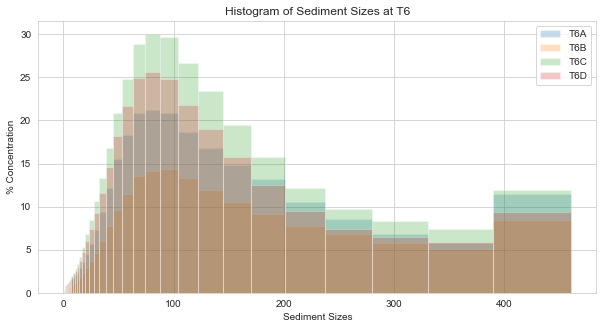

In [12]:
df = LISST_volconc[['T6A', 'T6B', 'T6C', 'T6D']]# the df to be tested for normality
sizes = LISST_volconc['Size (um)'] # the sizes of the sediment

# plotting the histogram
plt.figure(figsize=(10, 5))
sns.set_style('whitegrid')
plt.hist(sizes, weights=df['T6A'], bins=sizes, alpha=0.25, label='T6A')
plt.hist(sizes, weights=df['T6B'], bins=sizes, alpha=0.25, label='T6B')
plt.hist(sizes, weights=df['T6C'], bins=sizes, alpha=0.25, label='T6C')
plt.hist(sizes, weights=df['T6D'], bins=sizes, alpha=0.25, label='T6D')
plt.xlabel('Sediment Sizes')
plt.ylabel('% Concentration')
plt.title('Histogram of Sediment Sizes at T6')
plt.legend()
plt.show()

### Histogram: equally spaced bins

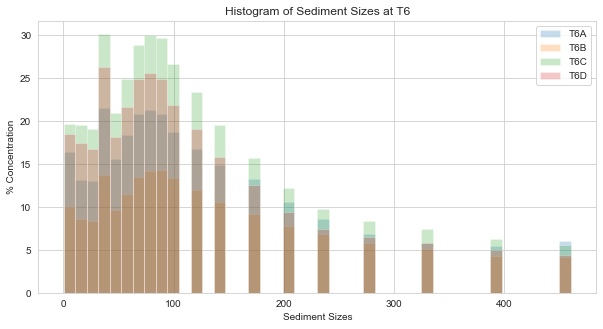

In [13]:
# plotting the histogram
plt.figure(figsize=(10, 5))
sns.set_style('whitegrid')
plt.hist(sizes, weights=df['T6A'], bins=len(sizes), alpha=0.25, label='T6A')
plt.hist(sizes, weights=df['T6B'], bins=len(sizes), alpha=0.25, label='T6B')
plt.hist(sizes, weights=df['T6C'], bins=len(sizes), alpha=0.25, label='T6C')
plt.hist(sizes, weights=df['T6D'], bins=len(sizes), alpha=0.25, label='T6D')
plt.xlabel('Sediment Sizes')
plt.ylabel('% Concentration')
plt.title('Histogram of Sediment Sizes at T6')
plt.legend()
plt.show()

It shows these spaces because there is no data that fell into the bins created

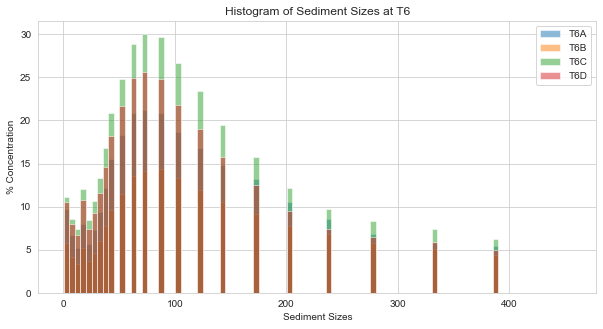

In [20]:
bins = np.arange(min(sizes), max(sizes), 5)  # custom bins (start, stop, step)

# plotting the histogram
plt.figure(figsize=(10, 5))
sns.set_style('whitegrid')
plt.hist(sizes, weights=df['T6A'], bins=bins, alpha=0.5, label='T6A')
plt.hist(sizes, weights=df['T6B'], bins=bins, alpha=0.5, label='T6B')
plt.hist(sizes, weights=df['T6C'], bins=bins, alpha=0.5, label='T6C')
plt.hist(sizes, weights=df['T6D'], bins=bins, alpha=0.5, label='T6D')
plt.xlabel('Sediment Sizes')
plt.ylabel('% Concentration')
plt.title('Histogram of Sediment Sizes at T6')
plt.legend()
plt.show()

We can see that these plots do not resemble a normal distribution, but to double check we will plot a Q-Q plot and applying the Kolmogorov-Smirnov test.

### Q-Q plot

We will first generate a table of all the percentiles of the distribution for all the basket samples (we will still only be looking at T6 though). We create this to have a higher resolution of the percentiles and not just by 10% intervals like we have in the raw data file 

In [21]:
# getting percentiles
percentiles = list(range(5, 100, 1))
# setting the sizes as the index
LISST_cumconc.set_index("Size (um)", inplace=True)

# interpolate the data to calculate percentiles
percentile_LISST = pd.DataFrame() # empty df
percentile_LISST['Percentiles'] = percentiles # changing the column name
percentile_LISST.set_index("Percentiles", inplace=True) # make it the index

for column_name in LISST_cumconc.columns: 
    interp = np.interp(percentiles, LISST_cumconc[column_name], LISST_cumconc.index)
    percentile_LISST[column_name] = interp # this adds the column name and results to the new df 

T6_percentiles = percentile_LISST[['T6A', 'T6B', 'T6C', 'T6D']]
T6_percentiles

,T6A,T6B,T6C,T6D
Percentiles,,,,
5,7.890000,9.133380,9.183684,8.110845
6,9.939600,11.327143,11.210000,9.968571
7,12.029091,13.475392,13.125726,11.826970
8,14.076698,15.540635,14.929189,13.590000
9,16.037405,17.523208,16.658919,15.263567
...,...,...,...,...
95,313.787465,323.942174,289.834928,281.389742
96,338.729655,346.525378,314.197246,307.384588
97,368.049852,371.533782,341.680000,334.512195


Now, we will save only the T6 columns, where the data of each column is the interpolated percentiles of the sediment sizes. 

In [23]:
# For our Q-Q plot we must transform these into quantile data
T6_quantiles = T6_percentiles
T6_quantiles.index = T6_percentiles.index / 100
T6_quantiles

,T6A,T6B,T6C,T6D
Percentiles,,,,
0.0005,7.890000,9.133380,9.183684,8.110845
0.0006,9.939600,11.327143,11.210000,9.968571
0.0007,12.029091,13.475392,13.125726,11.826970
0.0008,14.076698,15.540635,14.929189,13.590000
0.0009,16.037405,17.523208,16.658919,15.263567
...,...,...,...,...
0.0095,313.787465,323.942174,289.834928,281.389742
0.0096,338.729655,346.525378,314.197246,307.384588
0.0097,368.049852,371.533782,341.680000,334.512195


### This is incorrect, need to revisit*** 

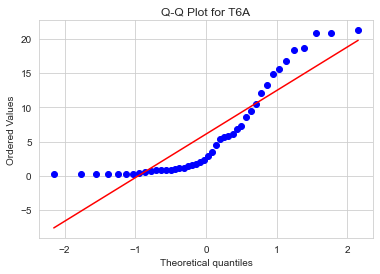

In [19]:
res = sp.stats.probplot(df, dist="norm", plot=plt)
plt.title("Q-Q Plot for T6A")
plt.show()

### Normality Tests

In [30]:
# Assuming 'sizes' is your list of bin edges and 'df' is the concentration in each bin
# Calculate the ECDF
ecdf = np.cumsum(df)

# Generate the quantiles of the theoretical normal distribution
quantiles = np.linspace(0.01, 0.99, len(sizes))  # Avoiding 0 and 1 for the ppf

# Calculate the corresponding values for these quantiles
values = norm.ppf(quantiles)

# Generate Q-Q plot
plt.plot(values, ecdf, 'o')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.title('Q-Q Plot')
plt.show()


NameError: name 'norm' is not defined

In [13]:
from scipy.stats import kruskal

# Perform Kruskal-Wallis test
stat, p_value = kruskal(LISST_volconc['T6A'], LISST_volconc['T6B'], LISST_volconc['T6C'], LISST_volconc['T6D'])

print(f"Kruskal-Wallis Statistic: {stat}")
print(f"P-value: {p_value}")

Kruskal-Wallis Statistic: 4.759328359329031
P-value: 0.1902927235692039


p > 0.10:
The result is not statistically significant, and there is insufficient evidence to reject the null hypothesis at the chosen significance level.